# Dependencies

In [1]:
%pip install lazypredict -q

In [2]:
%pip install rdkit -q

In [3]:
%pip install optuna -q

In [4]:
%pip install scikit-learn==1.2.2 -q

In [5]:
%pip install optuna-integration[sklearn] -q

In [6]:
%pip install catboost -q

In [150]:
import pickle
pickle.format_version

'4.0'

In [86]:
import pandas as pd
import numpy as np
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, balanced_accuracy_score, precision_score
import optuna
import matplotlib.pyplot as plt
import catboost as cb

# Data processing

In [8]:
data = pd.read_csv('KRAS-G12C.tsv', sep='\t')
data.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain
0,1396159,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,InChI=1S/C33H34F2N6O2/c1-19(34)32(42)41-14-13-...,DUTKHEXEPJBVCV-PQYNRNFHSA-N,663069,2-((2S)-4-(8-fluoro-2- ((S)-1-methylpyrrolidin...,GTPase KRas [G12C],NaN,NaN,0.490,...,GTPase KRas,RASK_HUMAN,P01116,A8K8Z5 B0LPF9 P01118 Q96D10,NaN,NaN,NaN,NaN,NaN,NaN
1,1396154,Fc1c(ncc2c(nc(OCC3(CN4CCCC4)CC3)nc12)N1CCN([C@...,InChI=1S/C35H35ClFN7O2/c1-2-28(45)44-18-17-43(...,WAAAKAKUJXFVAM-DEOSSOPVSA-N,663064,"US20240109893, Example 854",GTPase KRas [G12C],NaN,NaN,0.590,...,GTPase KRas,RASK_HUMAN,P01116,A8K8Z5 B0LPF9 P01118 Q96D10,NaN,NaN,NaN,NaN,NaN,NaN
2,1396157,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,InChI=1S/C34H34F3N7O2/c1-19(35)32(45)44-11-10-...,IMCVVGCTXVAANN-XHFWIQMNSA-N,663067,"2-((2S)-4-(8-fluoro-2- ((2R,7aS)-2- fluorotetr...",GTPase KRas [G12C],NaN,NaN,0.590,...,GTPase KRas,RASK_HUMAN,P01116,A8K8Z5 B0LPF9 P01118 Q96D10,NaN,NaN,NaN,NaN,NaN,NaN
3,1396158,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,InChI=1S/C33H35FN6O2/c1-3-29(41)40-15-14-39(18...,IHVADLOMEQNCDN-PQYNRNFHSA-N,663068,2-((2S)-1-acryloyl-4- (8-fluoro-2-((S)-1- meth...,GTPase KRas [G12C],NaN,NaN,0.710,...,GTPase KRas,RASK_HUMAN,P01116,A8K8Z5 B0LPF9 P01118 Q96D10,NaN,NaN,NaN,NaN,NaN,NaN
4,1396156,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,InChI=1S/C34H35F2N7O2/c1-2-28(44)43-12-11-41(1...,UPJZUKKSWTWBPO-XHFWIQMNSA-N,663066,"2-((2S)-1-acryloyl-4-(8- fluoro-2-((2R,7aS)-2-...",GTPase KRas [G12C],NaN,NaN,0.710,...,GTPase KRas,RASK_HUMAN,P01116,A8K8Z5 B0LPF9 P01118 Q96D10,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 50 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   BindingDB Reactant_set_id                                             1138 non-null   int64  
 1   Ligand SMILES                                                         1138 non-null   object 
 2   Ligand InChI                                                          1132 non-null   object 
 3   Ligand InChI Key                                                      1132 non-null   object 
 4   BindingDB MonomerID                                                   1138 non-null   int64  
 5   BindingDB Ligand Name                                                 1138 non-null   object 
 6   Target Name                                                           1138 non-null   object 
 7

In [10]:
df = data[['Ligand SMILES', 'IC50 (nM)']]
df

,Ligand SMILES,IC50 (nM)
0,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,0.490
1,Fc1c(ncc2c(nc(OCC3(CN4CCCC4)CC3)nc12)N1CCN([C@...,0.590
2,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,0.590
3,CN1CCC[C@H]1COc1nc(N2CCN([C@@H](CC#N)C2)C(=O)C...,0.710
4,F[C@H]1CN2CCC[C@@]2(COc2nc(N3CCN([C@@H](CC#N)C...,0.710
...,...,...
1133,CO[C@@H](C)c1ncccc1-c1c2CC(C)(C)COC(=O)[C@@H]3...,55.0
1134,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,55.0
1135,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,55.0
1136,CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...,55.0


In [11]:
df.rename(columns={'Ligand SMILES':'smiles', 'IC50 (nM)':'IC50'}, inplace=True)

In [12]:
def delete_symbols(x):
  if '>' in x:
    return float(x.replace('>', ''))
  elif '<' in x:
    return float(x.replace('<', ''))
  else:
    return float(x)

df.IC50 = df.IC50.apply(delete_symbols)

In [13]:
df.drop_duplicates(subset=['smiles', 'IC50'], inplace=True)
df.shape

(1047, 2)

In [14]:
repeated_smiles = df[df.smiles.duplicated()].smiles.unique()

In [15]:
# заполняем повторяющиеся стоки медианой
for smi in repeated_smiles:
  df_temp = df[df.smiles==smi]
  df.loc[df.smiles==smi, 'IC50'] = df_temp.IC50.median()

In [16]:
df.drop_duplicates(subset=['smiles', 'IC50'], inplace=True)
df.shape

(923, 2)

In [17]:
df['lgIC50'] = df.IC50.apply(np.log10)

<Axes: >

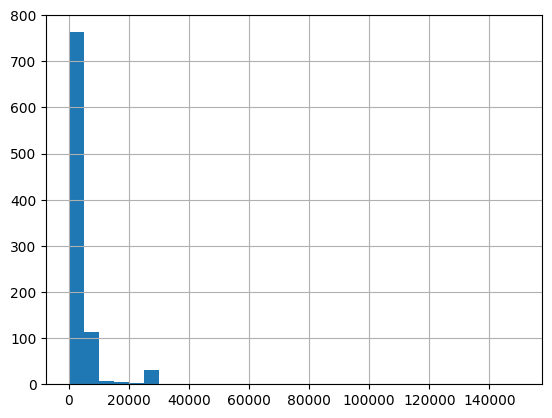

In [18]:
df.IC50.hist(bins=30)

<Axes: >

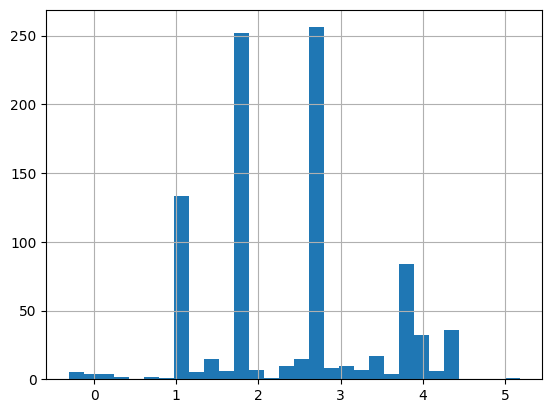

In [19]:
df.lgIC50.hist(bins=30)

In [20]:
df.lgIC50.mean()

2.3544443284337886

In [21]:
def get_fingerprint(smiles):
  '''Converts SMILES into Morgan fingerprint'''
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [22]:
# удаляем невалидные смайлзы
broken_smiles = ['CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@H](CC3CCC=[N](C3)c3ccc1c2c3)NC(=O)[C@H](C(C)C)N(C)C(=O)N1CCC2(CC1)CN(CCO2)C(=O)C=C)-c1cccnc1C(C)OC',
'CN(C)CC[N]1=C(C)C=C(N1)c1nn(C2CC3(C2)CN(C3)C(=O)C=C)c(C)c1-c1c(Cl)c(C)cc2[nH]ncc12']
df = df[df.smiles.isin(broken_smiles)==False]
df.shape

(921, 3)

In [23]:
df['fp'] = df.smiles.apply(get_fingerprint)

# Regression

In [24]:
X =  np.stack(df.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df.lgIC50.to_numpy()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,9044715350964016513024.00,-16123188234327158685696.00,117068406381.71,18.11
Lars,3588.44,-6394.00,73.73,0.56
LinearRegression,9.86,-14.79,3.66,0.23
TransformedTargetRegressor,9.86,-14.79,3.66,0.18
KernelRidge,5.46,-6.96,2.60,0.10
GaussianProcessRegressor,4.76,-5.70,2.39,0.84
LinearSVR,2.37,-1.44,1.44,1.09
Ridge,1.96,-0.72,1.21,0.05
HuberRegressor,1.70,-0.25,1.03,0.19


## LGBM

In [37]:
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
        "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
        "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
        "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
        "min_data_in_leaf": optuna.distributions.IntDistribution(1, 10),
    }
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
opt_search = optuna.integration.OptunaSearchCV(lgbm, param_distrs, cv = 5,
                                                n_trials=100, scoring='neg_root_mean_squared_error')

In [38]:
opt_search.fit(X_train, y_train)

[I 2024-09-30 08:52:04,905] A new study created in memory with name: no-name-9eccd575-58c2-429a-8f0d-ce6a0a5fcafa
[I 2024-09-30 08:52:19,218] Trial 0 finished with value: -0.6846338913063306 and parameters: {'n_estimators': 695, 'learning_rate': 0.03458778308930656, 'num_leaves': 102, 'subsample': 0.41944917588766883, 'colsample_bytree': 0.1356655500054894, 'min_data_in_leaf': 3}. Best is trial 0 with value: -0.6846338913063306.
[I 2024-09-30 08:52:20,548] Trial 1 finished with value: -0.6561378379922782 and parameters: {'n_estimators': 140, 'learning_rate': 0.019762764792469672, 'num_leaves': 142, 'subsample': 0.267709031008651, 'colsample_bytree': 0.5437977017402287, 'min_data_in_leaf': 7}. Best is trial 1 with value: -0.6561378379922782.
[I 2024-09-30 08:52:26,162] Trial 2 finished with value: -0.7277374812023065 and parameters: {'n_estimators': 558, 'learning_rate': 0.001997691196008454, 'num_leaves': 942, 'subsample': 0.4074937985726945, 'colsample_bytree': 0.9772510997319253, 'mi

OptunaSearchCV(cv=5, estimator=LGBMRegressor(random_state=42, verbose=-1),
               n_jobs=1, n_trials=100,
               param_distributions={'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.05, step=None),
                                    'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'min_data_in_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1),
                                    'num_leaves': IntDistribution(high=1024, log=False, low=2, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None)},
               scoring='neg_root_mean_squared_error', timeout=500)

In [40]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best RMSE:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 393, 'learning_rate': 0.009638076322399788, 'num_leaves': 626, 'subsample': 0.9047786729272379, 'colsample_bytree': 0.11952402483007438, 'min_data_in_leaf': 5}
Best RMSE: -0.6501176066224668


In [27]:
best_params = {'n_estimators': 393, 'learning_rate': 0.009638076322399788, 'num_leaves': 626, 'subsample': 0.9047786729272379, 'colsample_bytree': 0.11952402483007438, 'min_data_in_leaf': 5}
model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('train r2', r2_score(y_train, y_pred_train))
print('train rmse', mean_squared_error(y_train, y_pred_train, squared=False))
print('test r2', r2_score(y_test, y_pred_test))
print('test rmse', mean_squared_error(y_test, y_pred_test, squared=False))

train r2 0.8509668503655334
train rmse 0.4015003570279765
test r2 0.636701375002849
test rmse 0.5557073249604382


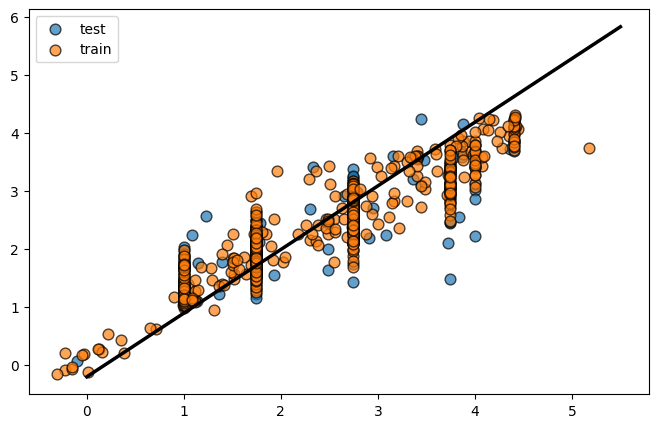

In [44]:
# Initialize layout
fig, ax = plt.subplots(figsize=(8, 5))

# Add scatterplot
ax.scatter(y_test, y_pred_test, s=60, alpha=0.7, edgecolors="k", label='test')

ax.scatter(y_train, y_pred_train, s=60, alpha=0.7, edgecolors="k", label='train')

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
rng = np.random.default_rng(1234)
x = rng.uniform(0, 5.5, size=100)
y = x + rng.normal(size=100)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 5.5, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
ax.legend()

## RF

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10)
    }
rf = RandomForestRegressor(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(rf, param_distrs, cv = 5,
                                                n_trials=100, scoring='neg_root_mean_squared_error')

In [83]:
opt_search.fit(X_train, y_train)

[I 2024-09-30 10:18:29,350] A new study created in memory with name: no-name-e8eacf24-c50f-40b2-819c-26234cfcdad5
[I 2024-09-30 10:18:43,318] Trial 0 finished with value: -0.6651294127721896 and parameters: {'n_estimators': 225, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.6651294127721896.
[I 2024-09-30 10:19:10,470] Trial 1 finished with value: -0.7315741602546744 and parameters: {'n_estimators': 777, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: -0.6651294127721896.
[I 2024-09-30 10:20:14,417] Trial 2 finished with value: -0.6597978246307102 and parameters: {'n_estimators': 839, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: -0.6597978246307102.
[I 2024-09-30 10:20:35,765] Trial 3 finished with value: -0.6639061003896463 and parameters: {'n_estimators': 360, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with

KeyboardInterrupt: 

In [ ]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best RMSE:', opt_search.best_score_)

In [30]:
best_params = {'n_estimators': 253, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}
model = RandomForestRegressor(random_state=42, **best_params)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('train r2', r2_score(y_train, y_pred_train))
print('train rmse', mean_squared_error(y_train, y_pred_train, squared=False))
print('test r2', r2_score(y_test, y_pred_test))
print('test rmse', mean_squared_error(y_test, y_pred_test, squared=False))

train r2 0.830104040139312
train rmse 0.4286827633803235
test r2 0.5982452633411797
test rmse 0.5843791968407802


## CatBoost

In [26]:
import catboost as cb
param_distrs = {
        "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
        "depth": optuna.distributions.IntDistribution(1, 10),
        "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
        "colsample_bylevel": optuna.distributions.FloatDistribution(0.05, 1.0),
        "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100),
    }
cb = cb.CatBoostRegressor(random_state=42, silent=True, iterations=500)
opt_search = optuna.integration.OptunaSearchCV(cb, param_distrs, cv = 5,
                                                n_trials=100, scoring='neg_root_mean_squared_error')

In [ ]:
opt_search.fit(X_train, y_train)

[I 2024-09-30 11:03:34,187] A new study created in memory with name: no-name-4affd80f-183f-4448-8f57-77babef3bdbc


KeyboardInterrupt: 

Exception ignored in: '_catboost._py_target_type_to_raw_target_data'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/numerictypes.py", line 357, in issubdtype
    @set_module('numpy')
KeyboardInterrupt: 


In [67]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best RMSE:', opt_search.best_score_)

Best hyperparameters: {'learning_rate': 0.051371344629480516, 'depth': 7, 'subsample': 0.2431719715532164, 'colsample_bylevel': 0.7548781461805618, 'min_data_in_leaf': 83}
Best RMSE: -0.6513287834069106


In [31]:
import catboost as cb
best_params = {'learning_rate': 0.051371344629480516, 'depth': 7, 'subsample': 0.2431719715532164, 'colsample_bylevel': 0.7548781461805618, 'min_data_in_leaf': 83}
model = cb.CatBoostRegressor(random_state=42, silent=True, iterations=500, **best_params)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('train r2', r2_score(y_train, y_pred_train))
print('train rmse', mean_squared_error(y_train, y_pred_train, squared=False))
print('test r2', r2_score(y_test, y_pred_test))
print('test rmse', mean_squared_error(y_test, y_pred_test, squared=False))

train r2 0.8737139431051695
train rmse 0.36959168969040157
test r2 0.6225843980933143
test rmse 0.5664012055174524


# Classification threshold=2.35

In [152]:
df['lgIC50_clf'] = df.lgIC50.apply(lambda x: 0 if x > 2.35 else 1)
y_clf = df.lgIC50_clf.to_numpy()

In [153]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [72]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train_clf, y_test_clf)

100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


In [73]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.84,0.84,0.84,0.84,0.78
ExtraTreesClassifier,0.82,0.82,0.82,0.82,0.66
LGBMClassifier,0.82,0.82,0.82,0.82,0.33
NuSVC,0.82,0.82,0.82,0.82,0.32
SVC,0.81,0.81,0.81,0.81,0.39
BaggingClassifier,0.81,0.81,0.81,0.81,0.25
XGBClassifier,0.81,0.80,0.80,0.81,0.90
RidgeClassifierCV,0.80,0.80,0.80,0.80,0.91
DecisionTreeClassifier,0.79,0.79,0.79,0.79,0.09


## RF

In [74]:
from sklearn.ensemble import RandomForestClassifier
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10)
    }
rf_clf = RandomForestClassifier(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(rf_clf, param_distrs, cv = 5,
                                                n_trials=100, scoring='accuracy')

In [76]:
opt_search.fit(X_train_clf, y_train_clf)

[I 2024-09-30 10:08:50,332] A new study created in memory with name: no-name-5df205bf-b0e0-4ef5-8c6e-7058914044ef
[I 2024-09-30 10:09:04,199] Trial 0 finished with value: 0.7580989152417723 and parameters: {'n_estimators': 653, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7580989152417723.
[I 2024-09-30 10:09:19,327] Trial 1 finished with value: 0.7635318992461849 and parameters: {'n_estimators': 786, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7635318992461849.
[I 2024-09-30 10:09:24,211] Trial 2 finished with value: 0.7635410921125206 and parameters: {'n_estimators': 374, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7635410921125206.
[I 2024-09-30 10:09:37,355] Trial 3 finished with value: 0.75133296561868 and parameters: {'n_estimators': 756, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with value: 

OptunaSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
               n_jobs=1, n_trials=100,
               param_distributions={'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1)},
               scoring='accuracy', timeout=500)

In [78]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 287, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 4}
Best RMSE: 0.7716951645523074


In [81]:
best_params = {'n_estimators': 287, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 4}
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train_clf, y_train_clf)
y_pred_test = model.predict(X_test_clf)
y_pred_train = model.predict(X_train_clf)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))

train accuracy 0.84375
train F1 0.8326055312954876
test accuracy 0.8378378378378378
test f1 0.8351648351648353


## LGBM

In [33]:
param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
        "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
        "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
        "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
        "min_data_in_leaf": optuna.distributions.IntDistribution(1, 10),
    }
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)
opt_search = optuna.integration.OptunaSearchCV(lgbm, param_distrs, cv = 5,
                                                n_trials=100, scoring='accuracy')

In [37]:
opt_search.fit(X_train_clf, y_train_clf)

[I 2024-09-30 11:08:56,139] A new study created in memory with name: no-name-e56b9017-1fef-4116-84ff-f617f9d28082
[I 2024-09-30 11:08:59,840] Trial 0 finished with value: 0.7581264938407795 and parameters: {'n_estimators': 469, 'learning_rate': 0.0928885013365423, 'num_leaves': 622, 'subsample': 0.709944961262563, 'colsample_bytree': 0.589253008080373, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.7581264938407795.
[I 2024-09-30 11:09:05,233] Trial 1 finished with value: 0.758108108108108 and parameters: {'n_estimators': 260, 'learning_rate': 0.00468363230867132, 'num_leaves': 227, 'subsample': 0.4186794759858962, 'colsample_bytree': 0.13697921724068335, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.7581264938407795.
[I 2024-09-30 11:09:08,179] Trial 2 finished with value: 0.7567567567567568 and parameters: {'n_estimators': 140, 'learning_rate': 0.0875324397752398, 'num_leaves': 822, 'subsample': 0.831645095732977, 'colsample_bytree': 0.8300511281395561, 'min_data_in_le

OptunaSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
               n_jobs=1, n_trials=100,
               param_distributions={'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.05, step=None),
                                    'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'min_data_in_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1),
                                    'num_leaves': IntDistribution(high=1024, log=False, low=2, step=1),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None)},
               scoring='accuracy')

In [38]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 345, 'learning_rate': 0.01638963308568226, 'num_leaves': 276, 'subsample': 0.2748742825243765, 'colsample_bytree': 0.5900684767732461, 'min_data_in_leaf': 7}
Best accuracy: 0.7785070785070785


In [39]:
best_params = {'n_estimators': 345, 'learning_rate': 0.01638963308568226, 'num_leaves': 276, 'subsample': 0.2748742825243765, 'colsample_bytree': 0.5900684767732461, 'min_data_in_leaf': 7}
model = lgb.LGBMClassifier(**best_params, random_state=42, verbose=-1)
model.fit(X_train_clf, y_train_clf)
y_pred_test = model.predict(X_test_clf)
y_pred_train = model.predict(X_train_clf)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))

train accuracy 0.9741847826086957
train F1 0.973049645390071
test accuracy 0.8108108108108109
test f1 0.8087431693989071


## Extra Trees [FINAL MODEL]

In [138]:
from sklearn.ensemble import ExtraTreesClassifier

param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10),
        "criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy'])
    }
et = ExtraTreesClassifier(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(et, param_distrs, cv = 5,
                                                n_trials=50, scoring='f1')

In [139]:
opt_search.fit(X_train_clf, y_train_clf)

[I 2024-09-30 15:30:20,454] A new study created in memory with name: no-name-d324a983-c323-4438-85c9-46f0f7422724
[I 2024-09-30 15:30:39,896] Trial 0 finished with value: 0.7432020785345833 and parameters: {'n_estimators': 827, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.7432020785345833.
[I 2024-09-30 15:30:50,597] Trial 1 finished with value: 0.7450159046216094 and parameters: {'n_estimators': 931, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7450159046216094.
[I 2024-09-30 15:31:04,883] Trial 2 finished with value: 0.7566620757078916 and parameters: {'n_estimators': 922, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7566620757078916.
[I 2024-09-30 15:31:15,751] Trial 3 finished with value: 0.7445992083127606 and parameters: {'n_estimators': 815, 'max_depth': 34, 'min

OptunaSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')),
                                    'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1)},
               scoring='f1')

In [140]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 102, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Best accuracy: 0.7632059560666372


In [154]:
best_params = {'n_estimators': 931, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'entropy'}
model = ExtraTreesClassifier(**best_params, random_state=42)
model.fit(X_train_clf, y_train_clf)
y_pred_test = model.predict(X_test_clf)
y_pred_train = model.predict(X_train_clf)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))
print('test precision', precision_score(y_test_clf, y_pred_test))

train accuracy 0.842391304347826
train F1 0.8304093567251462
test accuracy 0.8432432432432433
test f1 0.8415300546448088
test precision 0.8369565217391305


In [155]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_clf, y_pred_test)

array([[79, 15],
       [14, 77]])

In [156]:
pickle.dump(model, open('lung_cancer_model.pkl', 'wb'))

## SVC

In [54]:
from sklearn.svm import SVC

param_distrs = {
        "C": optuna.distributions.FloatDistribution(0.1, 1000),
        "gamma": optuna.distributions.FloatDistribution(0.0001, 1),
        "kernel": optuna.distributions.CategoricalDistribution(['rbf','poly'])
    }
svc = SVC()
opt_search = optuna.integration.OptunaSearchCV(svc, param_distrs, cv = 5,
                                                n_trials=50, scoring='accuracy')

In [55]:
opt_search.fit(X_train_clf, y_train_clf)

[I 2024-09-30 13:06:02,694] A new study created in memory with name: no-name-d043fe9f-f630-44f8-81f9-2948e4201af7
[I 2024-09-30 13:06:03,305] Trial 0 finished with value: 0.7648648648648648 and parameters: {'C': 6.2945056073906205, 'gamma': 0.014564701792994772, 'kernel': 'poly'}. Best is trial 0 with value: 0.7648648648648648.
[I 2024-09-30 13:06:04,203] Trial 1 finished with value: 0.5991726420297849 and parameters: {'C': 904.5068143366375, 'gamma': 0.4288445918613228, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7648648648648648.
[I 2024-09-30 13:06:04,607] Trial 2 finished with value: 0.7594134951277808 and parameters: {'C': 440.0108272483699, 'gamma': 0.7960673939874094, 'kernel': 'poly'}. Best is trial 0 with value: 0.7648648648648648.
[I 2024-09-30 13:06:05,036] Trial 3 finished with value: 0.7594134951277808 and parameters: {'C': 56.28173558048245, 'gamma': 0.6341035408847211, 'kernel': 'poly'}. Best is trial 0 with value: 0.7648648648648648.
[I 2024-09-30 13:06:05,455] Tria

OptunaSearchCV(cv=5, estimator=SVC(), n_jobs=1, n_trials=50,
               param_distributions={'C': FloatDistribution(high=1000.0, log=False, low=0.1, step=None),
                                    'gamma': FloatDistribution(high=1.0, log=False, low=0.0001, step=None),
                                    'kernel': CategoricalDistribution(choices=('rbf', 'poly'))},
               scoring='accuracy')

In [56]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'C': 22.545339228876735, 'gamma': 0.007445278417209489, 'kernel': 'rbf'}
Best accuracy: 0.7743886743886744


In [57]:
best_params = {'C': 22.545339228876735, 'gamma': 0.007445278417209489, 'kernel': 'rbf'}
model = SVC(**best_params)
model.fit(X_train_clf, y_train_clf)
y_pred_test = model.predict(X_test_clf)
y_pred_train = model.predict(X_train_clf)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))

train accuracy 0.9510869565217391
train F1 0.949438202247191
test accuracy 0.8054054054054054
test f1 0.8064516129032259


# Classification threshold=3

In [98]:
df['lgIC50_clf_3'] = df.lgIC50.apply(lambda x: 0 if x > 2 else 1)
y_clf_3 = df.lgIC50_clf_3.to_numpy()

In [99]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf_3, test_size=0.2, random_state=42)

In [100]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train_clf, y_test_clf)

100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


In [101]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.85,0.85,0.85,0.85,1.29
RandomForestClassifier,0.85,0.85,0.85,0.85,0.53
NuSVC,0.84,0.84,0.84,0.84,0.22
SVC,0.83,0.83,0.83,0.83,0.26
BaggingClassifier,0.82,0.82,0.82,0.82,1.03
LGBMClassifier,0.82,0.82,0.82,0.82,0.23
XGBClassifier,0.82,0.82,0.82,0.82,0.25
AdaBoostClassifier,0.81,0.81,0.81,0.81,1.05
DecisionTreeClassifier,0.79,0.79,0.79,0.79,0.28


In [120]:
from sklearn.ensemble import ExtraTreesClassifier

param_distrs = {
        "n_estimators": optuna.distributions.IntDistribution(100, 1000),
        "max_depth": optuna.distributions.IntDistribution(2, 50),
        "min_samples_split": optuna.distributions.IntDistribution(2, 10),
        "min_samples_leaf": optuna.distributions.IntDistribution(1, 10),
        "criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy'])
    }
et = ExtraTreesClassifier(random_state=42)
opt_search = optuna.integration.OptunaSearchCV(et, param_distrs, cv = 5,
                                                n_trials=50, scoring='f1')

In [121]:
opt_search.fit(X_train_clf, y_train_clf)

[I 2024-09-30 14:53:41,332] A new study created in memory with name: no-name-5c0efa48-ab68-43d6-94df-5899277cbdab
[I 2024-09-30 14:53:53,231] Trial 0 finished with value: 0.7369570132923441 and parameters: {'n_estimators': 764, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7369570132923441.
[I 2024-09-30 14:54:00,923] Trial 1 finished with value: 0.7365914218405704 and parameters: {'n_estimators': 570, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.7369570132923441.
[I 2024-09-30 14:54:06,068] Trial 2 finished with value: 0.7432096724383959 and parameters: {'n_estimators': 417, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 2 with value: 0.7432096724383959.
[I 2024-09-30 14:54:18,053] Trial 3 finished with value: 0.7377604299363105 and parameters: {'n_estimators': 956, 'max_depth': 41, 'min_sam

OptunaSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=1,
               n_trials=50,
               param_distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')),
                                    'max_depth': IntDistribution(high=50, log=False, low=2, step=1),
                                    'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1)},
               scoring='f1')

In [122]:
print('Best hyperparameters:', opt_search.best_params_)
print('Best accuracy:', opt_search.best_score_)

Best hyperparameters: {'n_estimators': 638, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
Best accuracy: 0.7570690585002644


In [127]:
best_params = {'n_estimators': 417, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}
model = ExtraTreesClassifier(**best_params, random_state=42)
model.fit(X_train_clf, y_train_clf)
y_pred_test = model.predict(X_test_clf)
y_pred_train = model.predict(X_train_clf)
print('train accuracy', accuracy_score(y_train_clf, y_pred_train))
print('train F1', f1_score(y_train_clf, y_pred_train))
print('test accuracy', accuracy_score(y_test_clf, y_pred_test))
print('test balanced accuracy', balanced_accuracy_score(y_test_clf, y_pred_test))
print('test f1', f1_score(y_test_clf, y_pred_test))
print('test precision', precision_score(y_test_clf, y_pred_test))

train accuracy 0.9130434782608695
train F1 0.9053254437869823
test accuracy 0.8486486486486486
test balanced accuracy 0.8484316479400749
test f1 0.842696629213483
test precision 0.8426966292134831


In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_clf, y_pred_test)

array([[82, 14],
       [14, 75]])